Overview:

Calculate object co-occurrences for MRF from ConceptNet word vectors using cosine similarity.

In [69]:
import numpy as np
import seaborn as sns
import pandas as pd
import gzip
import fastparquet
import matplotlib.pyplot as plt
import tensorflow as tf
import gensim.downloader as api

In [70]:
model = api.load('conceptnet-numberbatch-17-06-300')

In [71]:
# finalize object list
objects = pd.read_excel('post_objects.xlsx', header=None)

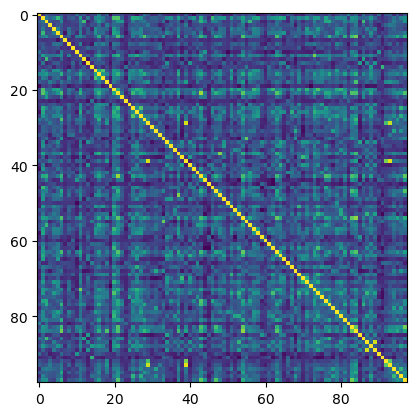

In [73]:
# create cooccurrence matrix 
word_vecs = np.zeros((len(objects), len(model.get_vector(objects.iloc[0][0]))))
cooccur = np.zeros((len(objects),len(objects)))

for i in range(len(objects)):
    
    word_vecs[i,:] = model.get_vector(objects.iloc[i][0])
    
    for j in range(len(objects)):
        
        cooccur[i,j] = model.similarity(objects.iloc[i][0],objects.iloc[j][0])

plt.imshow(coccuur)